# Create a butterfly diagram

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 14

import matplotlib.pyplot as plt
from glob import glob

paths = glob('Mt_Wilson_Tilt/*/gspot??.dat')

from astropy.time import Time
import astropy.units as u
import string
from astropy.table import Table

def split_interval(string, n, cast_to_type=float):
    return [cast_to_type(string[i:i+n]) for i in range(0, len(string), n)]

base_time = Time('1915-01-01')
all_years_array = []

header = ("jd n_spots_leading n_spots_following n_spots_day_1 n_spots_day_2 "
          "rotation_rate latitude_drift area_weighted_latitude_day_1 area_weighted_longitude_day_1 "
          "area_weighted_longitude_day_2 area_day_1 area_day_2 tilt_day_1 delta_polarity_separation "
          "area_weighted_longitude_day_1_leading area_weighted_longitude_day_1_following "
          "area_weighted_latitude_day_1_leading area_weighted_latitude_day_1_following "
          "area_leading area_following area_weighted_longitude_day_2_leading " 
          "area_weighted_longitude_day_2_following delta_tilt").split()

for path in paths:
    f = open(path).read().splitlines()

    n_rows = len(f) // 3
    n_columns = 23
    yearly_array = np.zeros((n_rows, n_columns))

    for i in range(n_rows):
        # First five ints specify time, afterwards specify sunspot data
        int_list = split_interval(f[0+i*3][:18], 2, int)
        month, day, year_minus_1900, hour, minute = int_list[:5]
        year = year_minus_1900 + 1900
        jd = Time("{year:d}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}"
                  .format(**locals())).jd
        row = [jd] + int_list[5:] + split_interval(f[1+i*3], 7) + split_interval(f[2+i*3][1:], 7)
        yearly_array[i, :] = row

    all_years_array.append(yearly_array)

table = Table(np.vstack(all_years_array), names=header)

In [2]:
table.add_index('jd')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


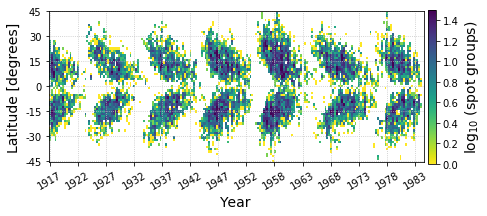

In [39]:
latitude_grid = np.linspace(-45, 45, 65)
time_grid = Time(np.linspace(Time('1917-01-01').jd, Time('1985-01-01').jd, 200), format='jd')

butterfly_grid = np.zeros((len(latitude_grid)-1, len(time_grid)))

for i in range(len(time_grid)-1):
    within_time_bin = ((table['jd'] > time_grid[i].jd) & 
                       (table['jd'] < time_grid[i+1].jd))
    spots_in_time_bin = table[within_time_bin]
    freq, edges = np.histogram(spots_in_time_bin['area_weighted_latitude_day_1'], bins=latitude_grid)
    butterfly_grid[:, i] = freq

fontsize = 14
fig, ax = plt.subplots(figsize=(8, 4.5))
cax = ax.imshow(np.log10(butterfly_grid),  cmap=plt.cm.viridis_r, 
                interpolation='nearest', origin='lower', vmax=1.5)
cbar = fig.colorbar(cax, pad=0.01, shrink=0.63)#, ticks=[-1, 0, 1])
cbar.ax.set_ylabel('$\log_{10}$ (spot groups)', fontsize=fontsize)
xtickskip = 15
ax.set_xticks(list(range(len(time_grid)))[::xtickskip])
ax.set_xticklabels([i.strftime("%Y") 
                    for i in time_grid[::xtickskip].datetime])

desired_yticks = np.arange(-45, 60, 15)
ax.set_yticks(np.interp(desired_yticks, latitude_grid, np.arange(len(latitude_grid))))
ax.set_yticklabels(desired_yticks)

plt.setp(ax.get_xticklabels(), rotation=30, ha='center')

ax.grid(color='silver', ls=':', zorder=-100)
ax.set_xlabel('Year', fontsize=fontsize) 
ax.set_ylabel('Latitude [degrees]', fontsize=fontsize)
ax.set_aspect(1.25)
fig.savefig("butterfly.pdf", bbox_inches='tight', dpi=200)
plt.show()